\begin{equation}

f(n, k) \leq Tower(n-1, 2k+1)
\end{equation}

In [4]:
from pybedtools import BedTool
import pybedtools
import pandas as pd
import numpy as np
import dask.dataframe as dd
import warnings
from scipy.stats import mannwhitneyu
from pathlib import Path

warnings.filterwarnings("ignore")
df_centro = pd.read_table("chm13v2.0_censat_v2.0.bed", 
                          usecols=range(4), 
                          skiprows=1, 
                          header=None, 
                          names=["seqID", "start", "end", "compartment"]
                         )
df_centro.loc[:, "compartment"] = df_centro["compartment"].str.split("_", expand=True)[0]

chrSizes = pd.read_table("genome_chromosome_sizess.txt")

chrSizes = chrSizes[chrSizes["organism"] == "chm13v2.0"].drop(columns=["organism"])\
                .rename(columns={"length": "chrLen"})

df_centro = df_centro.merge(chrSizes, how="left", on="seqID")
df_centro

/home/nicol/miniconda3/envs/avoidmers/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


,seqID,start,end,compartment,chrLen
0,chr1,116796047,121405145,ct,248387328
1,chr1,121405145,121406286,censat,248387328
2,chr1,121406286,121619169,ct,248387328
3,chr1,121619169,121625213,hor,248387328
4,chr1,121625213,121667941,hor,248387328
...,...,...,...,...,...
2518,chrY,62025776,62037362,censat,62460029
2519,chrY,62052955,62059882,censat,62460029
2520,chrY,62061431,62072743,hsat3,62460029
2521,chrY,62072743,62087298,bsat,62460029


In [5]:
from tqdm import tqdm

chromosomes =  {
                1: 'NC_060925.1',
                2: 'NC_060926.1',	
                3: 'NC_060927.1',
                4: 'NC_060928.1',
                5: 'NC_060929.1',
                6: 'NC_060930.1',
                7: 'NC_060931.1',
                8: 'NC_060932.1',
                9: 'NC_060933.1',	
                10: 'NC_060934.1',	
                11: 'NC_060935.1',	
                12: 'NC_060936.1',		
                13: 'NC_060937.1',	
                14: 'NC_060938.1',
                15: 'NC_060939.1',		
                16: 'NC_060940.1',		
                17: 'NC_060941.1',	
                18: 'NC_060942.1',	
                19: 'NC_060943.1',	
                20: 'NC_060944.1',	
                21: 'NC_060945.1',	
                22: 'NC_060946.1',	
                'X': 'NC_060947.1',
                'Y': 'NC_060948.1'
}
chromosomes = {v: f'chr{k}' for k, v in chromosomes.items()}

human_gff = pd.read_table("GCF_009914755.1_T2T-CHM13v2.0_genomic.gff.gz",
                          comment="#",
                          header=None,
                          names=["seqID", "source", "compartment", "start", "end", "score", "strand", "phase", "attributes"],
                         )
human_gff = human_gff[human_gff["compartment"].isin({"gene", "silencer", "CDS", "exon", "enhancer", "region"})].reset_index(drop=True)
human_gff = human_gff[["seqID", "start", "end", "compartment"]]
human_gff.loc[:, "start"] = human_gff["start"] - 1
human_gff.loc[:, "seqID"] = human_gff["seqID"].apply(lambda y: chromosomes[y])

compartments = ["region", "gene", "silencer", "CDS", "exon", "enhancer"]

merged_gff = []
for compartment in tqdm(compartments):
    limited_gff = ( 
                        BedTool.from_dataframe(human_gff[human_gff["compartment"] == compartment])
                       .sort()
                       .merge(c=["4", "4"], o=["count", "distinct"])
                  )
    limited_gff = pd.read_table(limited_gff.fn, 
                                header=None, 
                                names=["seqID", "start", "end", "totalCompartments", "compartment"]
                               )
    # limited_gff.loc[:, "compartment"] = compartment
    merged_gff.append(limited_gff)

merged_gff = pd.concat(merged_gff, axis=0)
merged_gff["compartment"] = merged_gff["compartment"].apply(lambda x: x.capitalize() if x != "CDS" else x)\
                                                .replace("Region", "Genome")
merged_gff

100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.41s/it]


,seqID,start,end,totalCompartments,compartment
0,chr1,0,248387328,1,Genome
1,chr10,0,134758134,1,Genome
2,chr11,0,135127769,1,Genome
3,chr12,0,133324548,1,Genome
4,chr13,0,113566686,1,Genome
...,...,...,...,...,...
85560,chrY,62080838,62081381,1,Enhancer
85561,chrY,62082582,62083084,1,Enhancer
85562,chrY,62086108,62086608,1,Enhancer
85563,chrY,62332803,62333355,1,Enhancer


In [6]:
merged_gff['seqID'].unique()

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrX', 'chrY'], dtype=object)

In [4]:
df_compartments = pd.concat([merged_gff, 
                             df_centro], 
                            axis=0)\
                        .drop(columns=['totalCompartments', 'chrLen'])

df_compartments

,seqID,start,end,compartment
0,chr1,0,248387328,Genome
1,chr10,0,134758134,Genome
2,chr11,0,135127769,Genome
3,chr12,0,133324548,Genome
4,chr13,0,113566686,Genome
...,...,...,...,...
2518,chrY,62025776,62037362,censat
2519,chrY,62052955,62059882,censat
2520,chrY,62061431,62072743,hsat3
2521,chrY,62072743,62087298,bsat


In [7]:
model_organisms = [f for f in Path("pattern_maximal_abacaba").glob("*.maximal.txt") if "chm13" in f.name]
model_organisms

[PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_words_length_50_seq_chr8.maximal.txt'),
 PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_words_length_50_seq_chr4.maximal.txt'),
 PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_words_length_50_seq_chr12.maximal.txt'),
 PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_words_length_50_seq_chr1.maximal.txt'),
 PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_words_length_50_seq_chrX.maximal.txt'),
 PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_words_length_50_seq_chr3.maximal.txt'),
 PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_words_length_50_seq_chrM.maximal.txt'),
 PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_words_length_50_seq_chr18.maximal.txt'),
 PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_words_length_50_seq_chr16.maximal.txt'),
 PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_words_length_50_seq_chr10.maximal.txt'),
 PosixPath('pattern_maximal_abacaba/chm13v2.0_abacaba_wo

In [8]:
model_organisms = [f for f in Path("pattern_maximal_abacaba").glob("*.maximal.txt") if "chm13" in f.name]
model_organisms
df_all = []

for species in tqdm(model_organisms):
    df = pd.read_csv(species)
    df_all.append(df)
    
df_all = pd.concat(df_all, axis=0)
df_all

100%|███████████████████████████████████████████| 25/25 [00:04<00:00,  5.08it/s]


,seqID,start,end,sequence,length,type
0,chr8,2692,2744,ctaactggtctctgaccttgattattaacggctgcaaccgggaaag...,52,abacaba
1,chr8,2721,2773,ggctgcaaccgggaaagattttattcaccgtcgatgcggccccgag...,52,abacaba
2,chr8,4032,4089,gcctcctgcaccacttaaagtcagagcgccagttattaatccccat...,57,abacaba
3,chr8,4624,4675,ctgacatttttattgcagtgaatgatgattggggcatcttaagaga...,51,abacaba
4,chr8,6142,6194,ttgatgttacttccaatcaaaagctaccatgcaattatttacataa...,52,abacaba
...,...,...,...,...,...,...
208289,chr11,135122238,135122288,gtctgtggccctgccatagaagcctgagttgatccacatgaaacca...,50,abacaba
208290,chr11,135122240,135122294,ctgtggccctgccatagaagcctgagttgatccacatgaaaccaac...,54,abacaba
208291,chr11,135122592,135122643,acagtgcctgggaagcacttggtaaatggcagctgtaattttgctc...,51,abacaba
208292,chr11,135122593,135122647,cagtgcctgggaagcacttggtaaatggcagctgtaattttgctct...,54,abacaba


In [9]:
zimin_enriched = pd.read_table("zimin_enriched.txt", header=None, 
                               names=["sequence", "totalAba", "abaDensity"],
                              dtype={"totalAba": int}
                                  )\
                    .drop_duplicates(subset=['sequence'])
zimin_enriched

,sequence,totalAba,abaDensity
0,ctaactggtctctgaccttgattattaacggctgcaaccgggaaag...,364,0.264151
1,ggctgcaaccgggaaagattttattcaccgtcgatgcggccccgag...,352,0.255443
2,gcctcctgcaccacttaaagtcagagcgccagttattaatccccat...,471,0.284936
3,ctgacatttttattgcagtgaatgatgattggggcatcttaagaga...,396,0.298643
4,ttgatgttacttccaatcaaaagctaccatgcaattatttacataa...,422,0.306241
...,...,...,...
4651248,gtctgtggccctgccatagaagcctgagttgatccacatgaaacca...,347,0.272157
4651249,ctgtggccctgccatagaagcctgagttgatccacatgaaaccaac...,413,0.278114
4651250,acagtgcctgggaagcacttggtaaatggcagctgtaattttgctc...,358,0.269985
4651251,cagtgcctgggaagcacttggtaaatggcagctgtaattttgctct...,404,0.272054


In [10]:
zimin_enriched['sequence'].drop_duplicates().to_csv("zimin_sequences.txt", index=False, header=False, mode="w")

In [8]:
zimin_combined = df_all.merge(
                            zimin_enriched,
                            how="left",
                            )
zimin_combined

,seqID,start,end,sequence,length,type,totalAba,abaDensity
0,chr8,2692,2744,ctaactggtctctgaccttgattattaacggctgcaaccgggaaag...,52,abacaba,364,0.264151
1,chr8,2721,2773,ggctgcaaccgggaaagattttattcaccgtcgatgcggccccgag...,52,abacaba,352,0.255443
2,chr8,4032,4089,gcctcctgcaccacttaaagtcagagcgccagttattaatccccat...,57,abacaba,471,0.284936
3,chr8,4624,4675,ctgacatttttattgcagtgaatgatgattggggcatcttaagaga...,51,abacaba,396,0.298643
4,chr8,6142,6194,ttgatgttacttccaatcaaaagctaccatgcaattatttacataa...,52,abacaba,422,0.306241
...,...,...,...,...,...,...,...,...
4651248,chr11,135122238,135122288,gtctgtggccctgccatagaagcctgagttgatccacatgaaacca...,50,abacaba,347,0.272157
4651249,chr11,135122240,135122294,ctgtggccctgccatagaagcctgagttgatccacatgaaaccaac...,54,abacaba,413,0.278114
4651250,chr11,135122592,135122643,acagtgcctgggaagcacttggtaaatggcagctgtaattttgctc...,51,abacaba,358,0.269985
4651251,chr11,135122593,135122647,cagtgcctgggaagcacttggtaaatggcagctgtaattttgctct...,54,abacaba,404,0.272054


In [9]:
zimin_combined['sequence'].value_counts().sort_values(ascending=False)

sequence
tcttcaccttgtgatccccttgccttggcctccaaatttgctgggattacaggcctgagccaagatccatatt    4212
ctgcaagtggatattcagacctctttgaggccttcgttggaaacgggatt                           3895
ggaatcgcaaggaattgatgtgaacggaacggaatggaatggaatccaaagg                         3567
gtttgtaaagtctgcaagtggatattcagacctccttgaggccttcgttggaa                        3408
ctgcaagtggatattcagacctccttgaggccttcgttggaaacgggatttctt                       3272
                                                                             ... 
agcctcagctaatcacagtagagctggactgttgtggttttccattcctt                              1
tggtagatgggtaaaagtatttaagtgtgtaccaagcaccgcagttcttctaa                           1
agcctatgaatcaccactggtgatgcaaagtcagaagagctaacatgtca                              1
ccagcctcaggaactggccaggtcgaattgcatttcccatgggcataaagttcaagatgctt                  1
ttgaacccagatctgcttgatgccaccaggatttacagtgttataaaatcatgc                          1
Name: count, Length: 4336951, dtype: int64

In [10]:
zimin_combined['abaDensity'].min()

np.float64(0.22549)

In [242]:
zimin_combined.shape

(4651253, 9)

In [243]:
sequences = list(zimin_combined['sequence'].drop_duplicates())

In [244]:
len(sequences)

4336951

In [ ]:
import numpy as np

jobs = {i: job for 

In [11]:
sorted_df = zimin_combined.sort_values(by=['abaDensity'], ascending=True)
sorted_df

,seqID,start,end,sequence,length,type,totalAba,abaDensity
1335950,chr3,12600315,12600366,aaccacttggcccccatatcctaaaaaaggacattttttgggggga...,51,abacaba,299,0.225490
2831371,chr2,88743215,88743265,ttattcccccaccaaaaactaatttttgcctcttgggggaggtgat...,50,abacaba,292,0.229020
2110125,chr10,134319335,134319385,ggattacagggtgagccaccgcgcccggcctcattttttaaaaaag...,50,abacaba,293,0.229804
2333459,chr7,142525815,142525866,aaccaaaagtaatgggggaagagctccccaccgtgccttccttttg...,51,abacaba,305,0.230015
3355190,chr15,75733811,75733861,tccgccaggccccaagaacggctctgttatttttggggtaattgaa...,50,abacaba,294,0.230588
...,...,...,...,...,...,...,...,...
4239927,chr13,10395721,10395772,attcctttccactcgtgttgattccattccattcaattccgttccg...,51,abacaba,558,0.420814
4420986,chrY,27810522,27810572,tggaatggaatggcatgggcaggaattgaattgaaatggttgaagt...,50,abacaba,539,0.422745
4434543,chrY,48762263,48762315,gaatagaacggaattgaattgaaaggaatcgaatgcaatggaatct...,52,abacaba,585,0.424528
4434555,chrY,48772829,48772881,gaatagaacggaattgaattgaaaggaatcgaatgcaatggaatct...,52,abacaba,585,0.424528


In [35]:
filtered_df = sorted_df[(sorted_df['sequence'].str.extract("([g]{4,})").isna() \
                         & sorted_df['sequence'].str.extract("([t]{4,})").isna() \
                         & sorted_df['sequence'].str.extract("([a]{4,})").isna() \
                         & sorted_df['sequence'].str.extract("([c]{4,})").isna())[0]]
#index
filtered_df

,seqID,start,end,sequence,length,type,totalAba,abaDensity
2424231,chr22,45035844,45035896,acggcaaacttaatggaggaatatcgtgtgttctctaagggttccg...,52,abacaba,329,0.238752
529597,chr12,24773363,24773415,ttcgcgagcatccttgtttattaaacaacctctaggtgaatggccg...,52,abacaba,330,0.239478
3029545,chr2,223731364,223731414,ggcaatttggtccgctcctgggaggacaccatattaatgccaaact...,50,abacaba,306,0.240000
91869,chr8,58304594,58304644,aagtgctgggattacaggcgtaaccaaacctcctttcttaatggcc...,50,abacaba,306,0.240000
2779582,chr2,55118128,55118178,ggtctcctttcagggttaacttgaccaataaggaaaccctggtggc...,50,abacaba,306,0.240000
...,...,...,...,...,...,...,...,...
4239927,chr13,10395721,10395772,attcctttccactcgtgttgattccattccattcaattccgttccg...,51,abacaba,558,0.420814
4420986,chrY,27810522,27810572,tggaatggaatggcatgggcaggaattgaattgaaatggttgaagt...,50,abacaba,539,0.422745
4434543,chrY,48762263,48762315,gaatagaacggaattgaattgaaaggaatcgaatgcaatggaatct...,52,abacaba,585,0.424528
4434555,chrY,48772829,48772881,gaatagaacggaattgaattgaaaggaatcgaatgcaatggaatct...,52,abacaba,585,0.424528


In [12]:
len(sorted_df.head(20)['sequence'].iloc[0])

51

In [13]:
# x = "agatataaaaag"

# for n in x:
#     for n2 in "agct":
#         if x[0] == n2:
#             continue
            
        
#     print(n)

In [14]:
import matplotlib.pyplot as plt 
import seaborn as sns

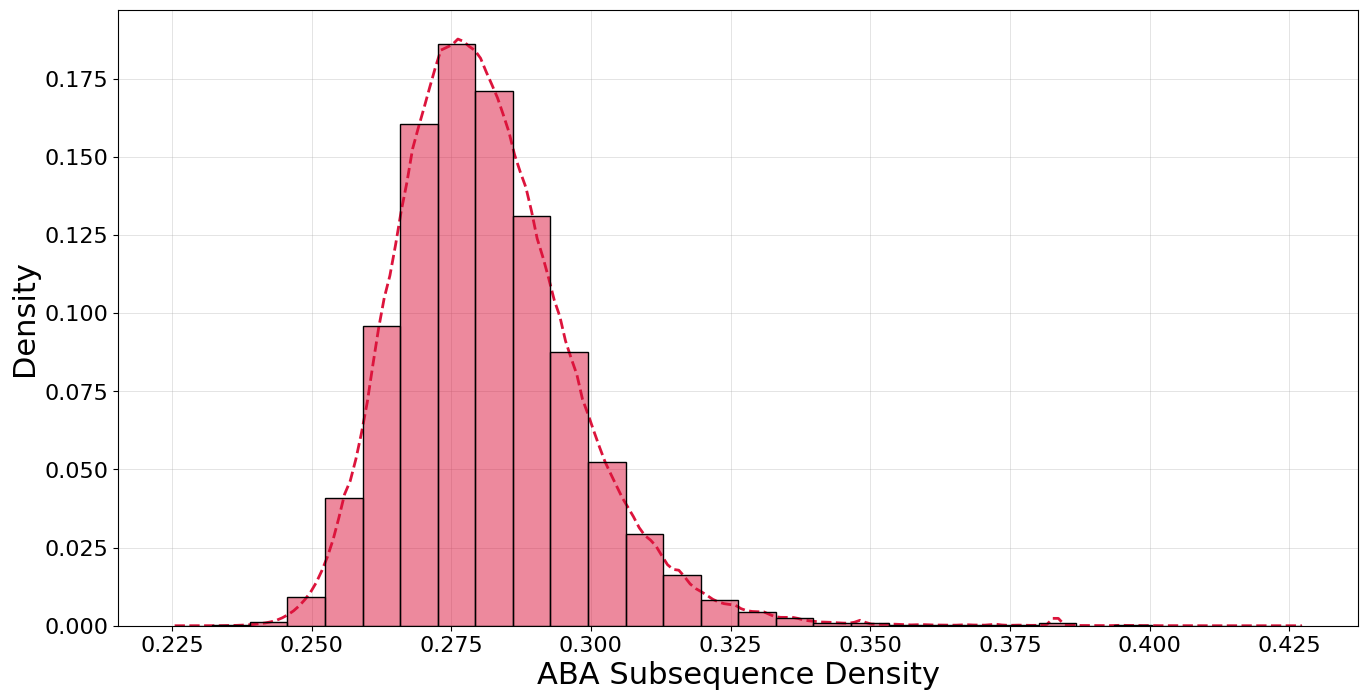

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
sns.histplot(data=zimin_combined, 
             x="abaDensity", 
             kde=True, 
             line_kws={'color': 'black', 'lw': 2.0, 'ls': '--'}, 
             bins=30, 
             ax=ax, 
             zorder=3, 
             stat="proportion", 
             color="crimson"
            )
ax.grid(lw=0.4, alpha=0.6, zorder=0)

ax.set_xlabel("ABA Subsequence Density")
ax.xaxis.label.set_size(22)
ax.set_ylabel("Density")
ax.yaxis.label.set_size(22)
ax.tick_params(axis="both", labelsize=16)
ax.set_axisbelow(True)

In [16]:
binns = pd.qcut(zimin_combined['abaDensity'], q=10)
zimin_combined["bins"] = binns

# Avoidmer Diversity

In [42]:
import math


# 64 | 100 <---- 

def find_diversity(kmer, kmer_length: int = 3):
    diversity = set()
    N = len(kmer)
    for i in range(N-kmer_length+1):
        diversity.add(kmer[i:i+kmer_length])
        
    return len(diversity) / (N-kmer_length+1)
    

def find_entropy(kmer, kmer_length: int=3):
    entropy = defaultdict(int)
    N = len(kmer)
    for i in range(N-kmer_length+1):
        entropy[kmer[i:i+kmer_length]] += 1

    ent = 0.0
    for key, value in entropy.items():
        entropy[key] = value / (N - kmer_length + 1)
        ent -= math.log(entropy[key], 2) * entropy[key]
        
    return ent

from collections import defaultdict, Counter

entropy = find_entropy("ataaa")
entropy

1.584962500721156

In [28]:
zimin_combined.head()

,seqID,start,end,sequence,length,type,totalAba,abaDensity,bins
0,chr8,2692,2744,ctaactggtctctgaccttgattattaacggctgcaaccgggaaag...,52,abacaba,364,0.264151,"(0.263, 0.268]"
1,chr8,2721,2773,ggctgcaaccgggaaagattttattcaccgtcgatgcggccccgag...,52,abacaba,352,0.255443,"(0.224, 0.263]"
2,chr8,4032,4089,gcctcctgcaccacttaaagtcagagcgccagttattaatccccat...,57,abacaba,471,0.284936,"(0.283, 0.288]"
3,chr8,4624,4675,ctgacatttttattgcagtgaatgatgattggggcatcttaagaga...,51,abacaba,396,0.298643,"(0.293, 0.301]"
4,chr8,6142,6194,ttgatgttacttccaatcaaaagctaccatgcaattatttacataa...,52,abacaba,422,0.306241,"(0.301, 0.427]"


In [43]:
stats = defaultdict(list)

for _, row in tqdm(zimin_combined.iterrows(), total=zimin_combined.shape[0]):
    sequence = row['sequence']
    seq_ent = find_entropy(sequence)
    diversity = find_diversity(sequence)

    stats["diversity"].append(diversity)
    stats["entropy"].append(seq_ent)
    stats["abaDensity"].append(row['abaDensity'])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4651253/4651253 [02:49<00:00, 27520.59it/s]


In [58]:
stats = pd.DataFrame(stats)
stats

,diversity,entropy,abaDensity
0,0.700000,4.983465,0.264151
1,0.760000,5.148758,0.255443
2,0.654545,5.021824,0.284936
3,0.632653,4.808388,0.298643
4,0.700000,4.998563,0.306241
...,...,...,...
4651248,0.750000,5.022055,0.272157
4651249,0.711538,5.041504,0.278114
4651250,0.693878,4.971653,0.269985
4651251,0.711538,5.094483,0.272054


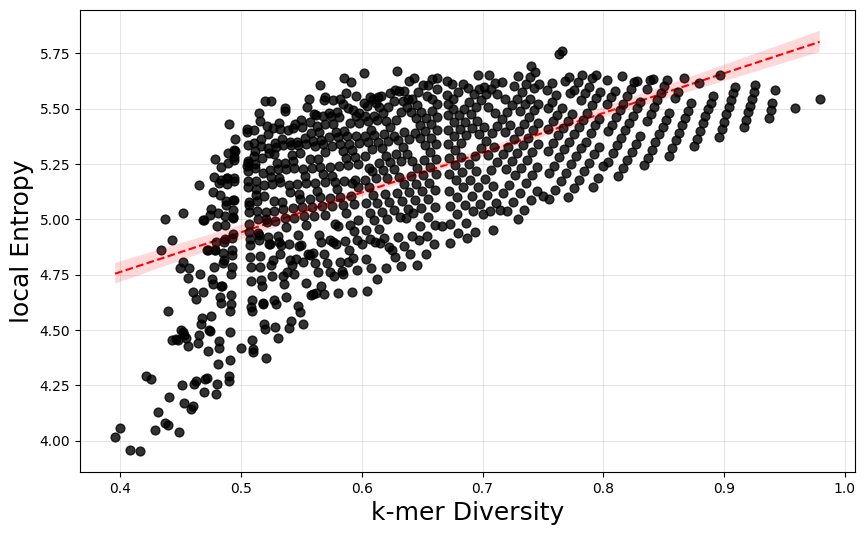

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
stats_avg = stats.groupby("diversity", as_index=False).agg({"entropy": "mean"})
sns.regplot(data=stats_avg, 
            x="diversity", 
            y="entropy", 
            ax=ax, 
            line_kws={"color": "red", "lw": 1.5, "linestyle": "--", "zorder": 0},
           scatter_kws={"s": 40, "color": "black"})
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("k-mer Diversity")
ax.set_ylabel("local Entropy")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.set_axisbelow(True)

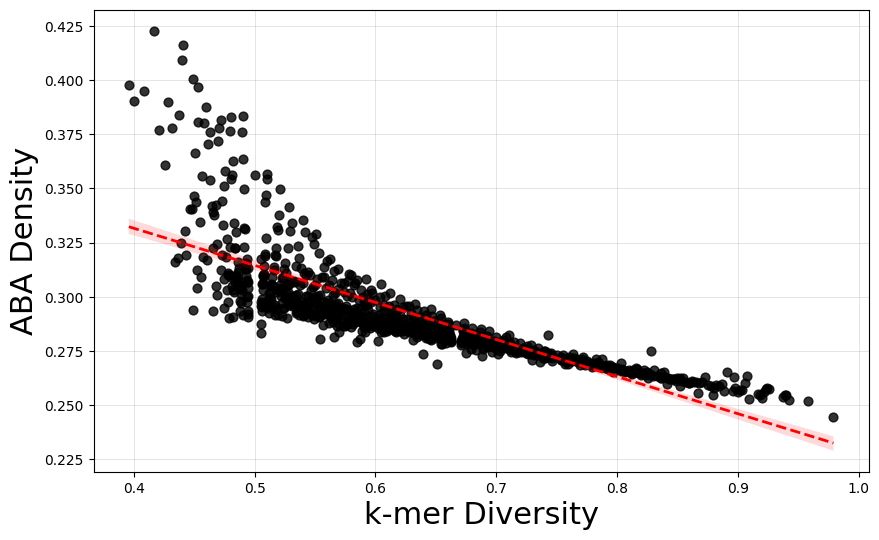

In [74]:
stats_avg = stats.groupby("diversity", as_index=False).agg({"abaDensity": "mean"})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.regplot(data=stats_avg, 
            x="diversity", 
            y="abaDensity", 
            ax=ax, 
            line_kws={"color": "red", "lw": 2.0, "linestyle": "--"},
           scatter_kws={"s": 40, "color": "black"})
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("k-mer Diversity")
ax.set_ylabel("ABA Density")
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.set_axisbelow(True)

MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(0.0))


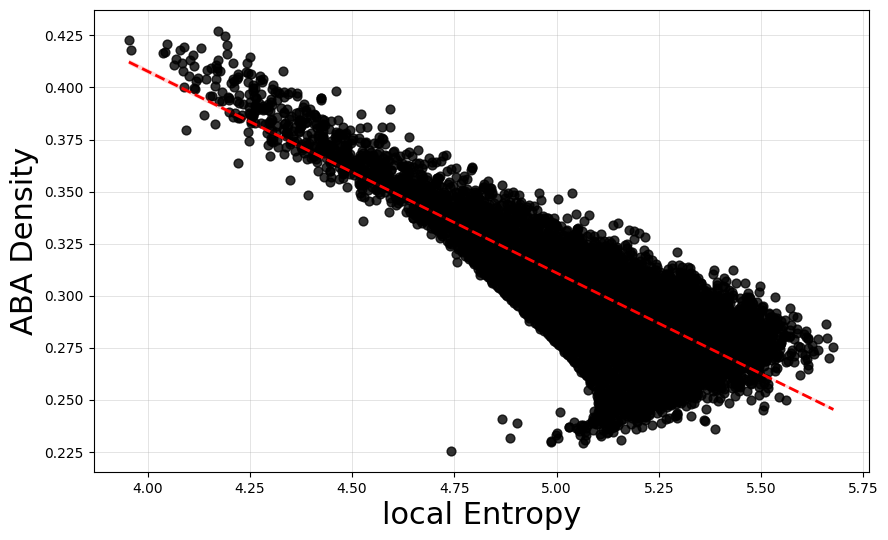

In [76]:
stats_avg = stats.groupby("abaDensity", as_index=False).agg({"entropy": "mean"})

print(mannwhitneyu(stats_avg["abaDensity"], stats_avg["entropy"]))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.regplot(data=stats_avg, 
            x="entropy", 
            y="abaDensity", 
            ax=ax, 
            line_kws={"color": "red", "lw": 2.0, "linestyle": "--"},
           scatter_kws={"s": 40, "color": "black"})
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_ylabel("ABA Density")
ax.set_xlabel("local Entropy")
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.set_axisbelow(True)

# Zimin Mutations

#### insertions


In [49]:
!python --version

Python 3.11.9


In [231]:
import re
import abc

class Mutator(abc.ABC):

    def __init__(self, alphabet: str = "agct") -> None:
        self.alphabet = alphabet
        # self.avoidmers = set()

    @abc.abstractmethod
    def is_invariant(self, sequence: str) -> bool:
        raise NotImplementedError()

    def mutate(self, sequence: str) -> dict[str, float | str | list[int]]:
        snp_invariance, positions_snp = self.mut_snp(sequence)
        del_invariance, positions_del = self.mut_deletions(sequence)
        ins_invariance, positions_ins = self.mut_insertions(sequence)

        return {
                "snp": snp_invariance,
                "snp_positions": positions_snp,
                "del": del_invariance,
                "del_positions": positions_del,
                "ins": ins_invariance,
                "ins_positions": positions_ins,
                "sequence": sequence,
                "is_invariant": self.is_invariant(sequence),
            }

    def mut_snp(self, sequence: str) -> float:
        invariant = 0
        N = len(sequence)
        total_mutations = 3 * N
        sequence = list(sequence)
        positions = [0 for _ in range(N)]
        
        # 3 X N total SNP
        for i in range(N):
            allele = sequence[i] # allele 
            
            for mut in self.alphabet: # agct = nucleotide alphabet
                if mut == allele:  # continue
                    continue

                sequence[i] = mut
                mutated_sequence = ''.join(sequence)
                
                # caching
                # if mutated_sequence in self.avoidmers:
                #     positions[i] += 1
                #     survived += 1
                #     total += 1
                #     sequence[i] = allele
                #     continue
                
                # bottleneck
                if self.is_invariant(mutated_sequence):
                    invariant += 1
                    positions[i] += 1
                    # self.avoidmers.add(seq)
                
            sequence[i] = allele
            
        return invariant / float(total_mutations), positions

    def mut_insertions(self, sequence: str) -> float:
        invariant = 0
        N = len(sequence)
        total_mutations = (N+1) *   4
        positions = [0 for _ in range(N+1)]

        for i in range(N+1):
            for mut in self.alphabet: # agct = nucleotides
                mutated_sequence = sequence[:i] + mut + sequence[i:]
                
                # caching
                # if mutated_sequence in self.avoidmers:
                #     survived += 1
                #     total += 1
                #     position[i] += 1
                #     continue
                
                # bottleneck
                if self.is_invariant(mutated_sequence):
                    invariant += 1
                    positions[i] += 1
                    # self.avoidmers.add(mutated_sequence)
                
        return invariant / float(total_mutations), positions

    def mut_deletions(self, sequence: str) -> float:
        invariant = 0
        N = len(sequence)
        total_mutations = N
        positions = [0 for _ in range(N)]

        # N deletions
        for i in range(N):
            mutated_sequence = sequence[:i] + sequence[i+1:]
            
            # caching
            # if mutated_sequence in self.avoidmers:
            #     survived += 1
            #     total += 1
            #     positions[i] += 1
            #     continue
            
            # bottleneck
            if self.is_invariant(mutated_sequence):
                positions[i] += 1
                invariant += 1
                # self.avoidmers.add(mutated_sequence)
                
        return invariant / float(total_mutations), positions

    def __repr__(self) -> str:
        return f"Sequence Mutator: {type(self).__name__} using Alphabet({''.join(self.alphabet)})."

class AvoidmerMutator(Mutator):

    def __init__(self, alphabet: str = "agct") -> None:
        super().__init__(alphabet)

    def is_invariant(self, sequence: str) -> bool:
        return re.search(r"(.+)(.+)\1(.+)\1\2\1", sequence) is None

class AbaMutator(Mutator):

    def is_invariant(self, sequence: str) -> bool:
        return re.search(r"(.+)(.+)\1", sequence) is None

In [213]:
mutator = AvoidmerMutator()
mutator

Sequence Mutator: AvoidmerMutator using Alphabet(agct).

In [233]:
aba_mutator = AbaMutator()
aba_mutator

Sequence Mutator: AbaMutator using Alphabet(agct).

In [234]:
aba_mutator.is_invariant("ggttccaa")

True

In [238]:
7 / 9

0.7777777777777778

In [239]:
aba_mutator.mutate(sequence="ggt") #ggg # tgt # 

{'snp': 0.7777777777777778,
 'snp_positions': [2, 3, 2],
 'del': 1.0,
 'del_positions': [1, 1, 1],
 'ins': 0.5,
 'ins_positions': [2, 0, 3, 3],
 'sequence': 'ggt',
 'is_invariant': True}

In [138]:
seq = "agtagatcgcgccgt"
is_avoidmer(seq)

True

In [139]:
mutator.mutate("agtagatcgcgccgt")

0.9777777777777777

In [141]:
len(mutator.avoidmers), len(seq)

(44, 15)

In [142]:
15 * 3

45

In [105]:
survivors = defaultdict(list)

for _, row in tqdm(zimin_combined.iterrows(), total=zimin_combined.shape[0]):
    sequence = row['sequence']
    abaDensity = row['abaDensity']
    survived = mutator.mutate(sequence)
    # diversity = find_diversity(sequence)
    survivors["abaDensity"].append(abaDensity)
    survivors["survived"].append(survived)
    # survivors["diversity"].append(diversity)
    
survivors = pd.DataFrame(survivors)
survivors

  0%|                                                                                                                                         | 3240/4651253 [01:53<45:21:05, 28.47it/s]


KeyboardInterrupt: 

In [90]:
survivors = pd.DataFrame(survivors)
survivors

,abaDensity,survived
0,0.264151,0.764423
1,0.255443,0.735577
2,0.284936,0.679825
3,0.298643,0.735294
4,0.306241,0.730769
...,...,...
2070,0.288215,0.722222
2071,0.289776,0.710526
2072,0.290710,0.683333
2073,0.259071,0.658654


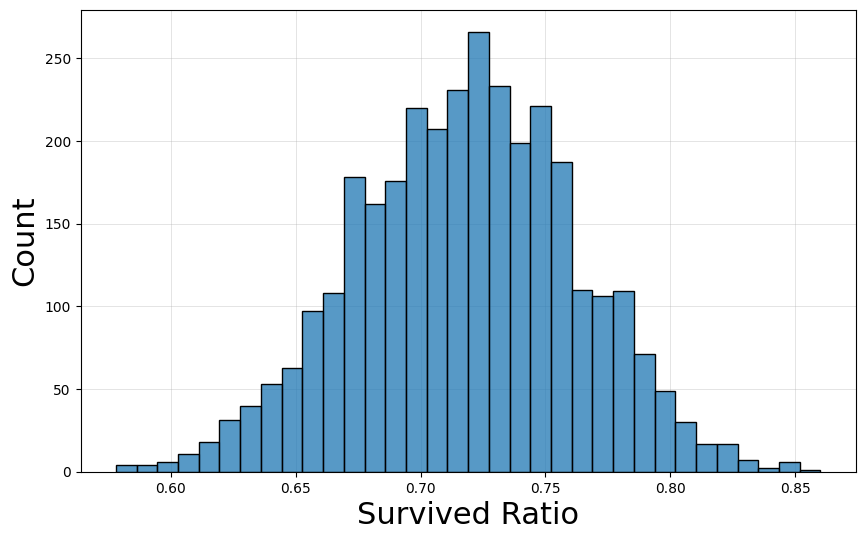

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.histplot(data=survivors, 
            x="survived", 
            ax=ax, 
      )
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("Survived Ratio")
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.set_axisbelow(True)

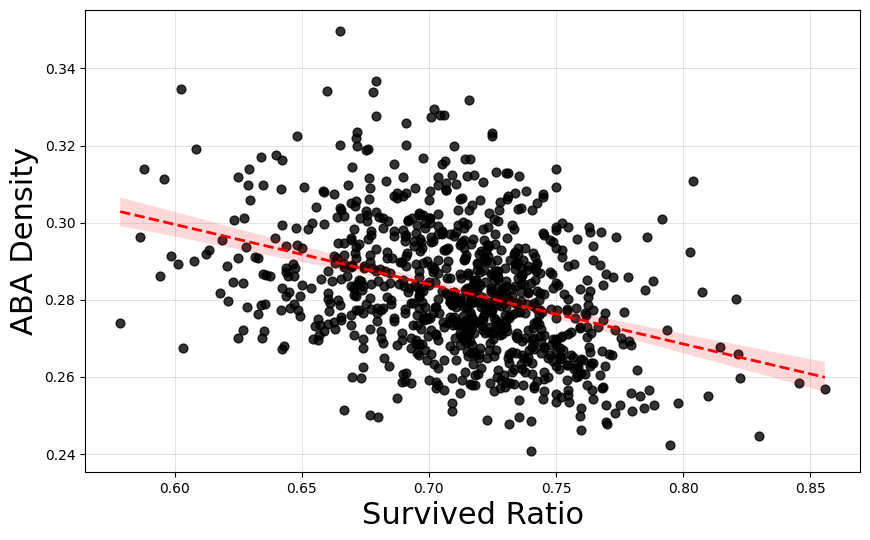

In [91]:
survivors_avg = survivors.groupby("abaDensity", as_index=False).agg({"survived": "mean"})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.regplot(data=survivors_avg, 
            x="survived", 
            y="abaDensity", 
            ax=ax, 
            line_kws={"color": "red", "lw": 2.0, "linestyle": "--"},
           scatter_kws={"s": 40, "color": "black"})
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_ylabel("ABA Density")
ax.set_xlabel("Survived Ratio")
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.set_axisbelow(True)

In [19]:
compartments_bed = BedTool.from_dataframe(df_compartments)

In [35]:
zimin_combined.bins.value_counts()

bins
(0.268, 0.272]    473533
(0.283, 0.288]    467600
(0.293, 0.301]    466303
(0.263, 0.268]    466140
(0.224, 0.263]    466025
(0.279, 0.283]    465001
(0.272, 0.276]    464595
(0.301, 0.427]    463817
(0.288, 0.293]    462303
(0.276, 0.279]    455936
Name: count, dtype: int64

In [36]:
binns_coverage = []
unique_bins = zimin_combined['bins'].nunique()
from tqdm import tqdm
for binns, group in tqdm(zimin_combined.groupby("bins"), total=unique_bins):
    bed = BedTool.from_dataframe(group)
    coverage_df = pd.read_table(
                        compartments_bed.coverage(bed).fn,
                        header=None,
                        names=["seqID", 
                               "start", 
                               "end", 
                               "compartment", 
                               "totalHits", 
                               "overlapingBp", 
                               "compartmentLength", 
                               "coverage"]
                    )
    coverage_df.loc[:, "binns"] = binns
    binns_coverage.append(coverage_df)

binns_coverage = pd.concat(binns_coverage, axis=0)
binns_coverage

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:02<00:00, 12.26s/it]


,seqID,start,end,compartment,totalHits,overlapingBp,compartmentLength,coverage,binns
0,chr1,0,248387328,Genome,47059,2216576,248387328,0.008924,"(0.224, 0.263]"
1,chr10,0,134758134,Genome,21475,1042533,134758134,0.007736,"(0.224, 0.263]"
2,chr11,0,135127769,Genome,19751,965276,135127769,0.007143,"(0.224, 0.263]"
3,chr12,0,133324548,Genome,22157,1085736,133324548,0.008144,"(0.224, 0.263]"
4,chr13,0,113566686,Genome,13004,632060,113566686,0.005566,"(0.224, 0.263]"
...,...,...,...,...,...,...,...,...,...
676739,chrY,62025776,62037362,censat,3,153,11586,0.013206,"(0.301, 0.427]"
676740,chrY,62052955,62059882,censat,0,0,6927,0.000000,"(0.301, 0.427]"
676741,chrY,62061431,62072743,hsat3,0,0,11312,0.000000,"(0.301, 0.427]"
676742,chrY,62072743,62087298,bsat,0,0,14555,0.000000,"(0.301, 0.427]"


In [1]:
binns_coverage.head()

NameError: name 'binns_coverage' is not defined

In [37]:
binns_coverage_pivot = (
                        binns_coverage.groupby(["seqID", "start", "end", "compartment", "binns"], as_index=False)
                                     .agg(
                                          totalLength=("compartmentLength", "first"),
                                          coverage=("overlapingBp", "sum")
                                        )
                                .groupby(["compartment", "binns"], as_index=False)
                                .agg(totalLength=("totalLength", "sum"),
                                     coverage=("coverage", "sum")
                                    )
                                .assign(coverage=lambda ds: 1e2 * ds['coverage'].div(ds['totalLength']))
                                .pivot(index="compartment", columns="binns", values="coverage")
                            )
binns_coverage_pivot

binns,"(0.224, 0.263]","(0.263, 0.268]","(0.268, 0.272]","(0.272, 0.276]","(0.276, 0.279]","(0.279, 0.283]","(0.283, 0.288]","(0.288, 0.293]","(0.293, 0.301]","(0.301, 0.427]"
compartment,,,,,,,,,,
CDS,0.956111,1.103938,1.177310,1.211062,1.236128,1.271255,1.290556,1.215673,1.190503,1.025959
Enhancer,1.010833,0.959057,0.938876,0.919788,0.887195,0.890282,0.880863,0.857361,0.828887,0.732133
Exon,0.849893,0.944585,0.964061,0.979865,0.972408,1.012439,1.023623,0.962380,0.937961,0.801095
Gene,0.753668,0.804613,0.834370,0.831744,0.823607,0.840574,0.840556,0.817164,0.813279,0.725800
Genome,0.722613,0.760093,0.788990,0.784531,0.770484,0.787096,0.789239,0.773052,0.768474,0.704077
Silencer,0.552894,0.560519,0.527486,0.565813,0.544237,0.574483,0.577579,0.558349,0.545470,0.532820
bsat,0.631959,0.746387,0.729465,1.577412,0.481490,0.450107,0.367654,0.372508,0.358234,0.294690
censat,0.698411,0.956835,0.946916,0.816436,0.751270,0.847617,0.782080,0.594311,0.572835,0.494238
ct,0.716274,0.779918,0.800004,0.805611,0.799664,0.815478,0.824887,0.802666,0.792021,0.694702


In [38]:
binns_coverage_pivot_log = binns_coverage_pivot.copy()
for col in binns_coverage_pivot:
    binns_coverage_pivot_log[col] = binns_coverage_pivot[col].apply(lambda x: math.log(x+1, 10))

<Axes: xlabel='binns', ylabel='compartment'>

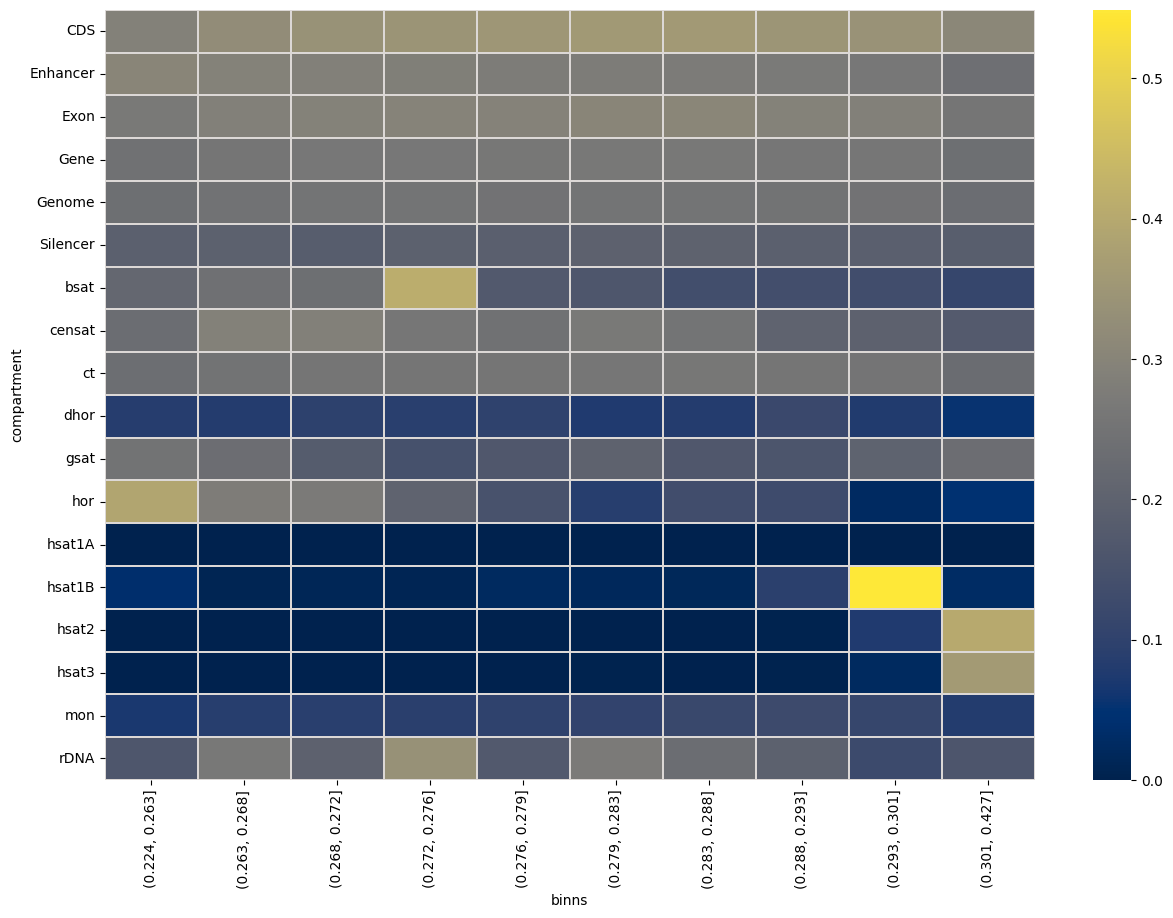

In [48]:
import math
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.heatmap(data=binns_coverage_pivot_log, ax=ax, linecolor='#dcd8d6', cmap="cividis", lw=0.01)

<Axes: xlabel='binns', ylabel='coverage'>

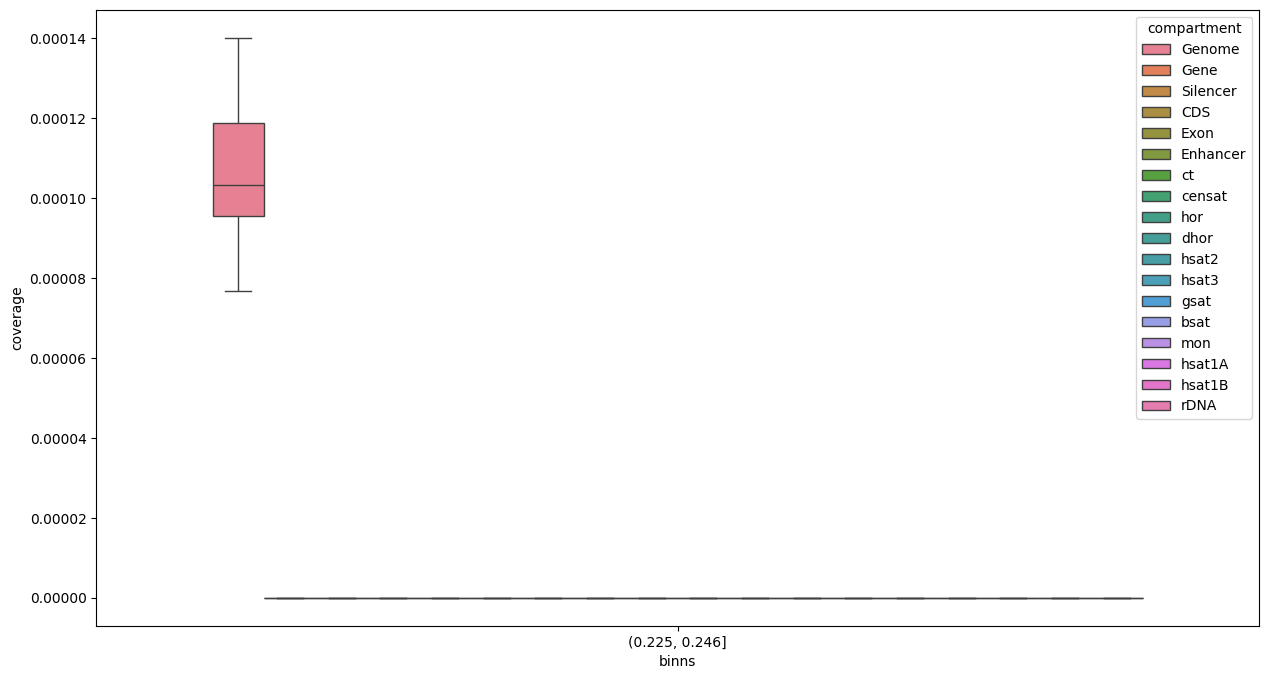

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.boxplot(data=binns_coverage, showfliers=False, hue="compartment", dodge=False, x="binns", y="coverage", ax=ax)

In [ ]:
inter_df.groupby(["bins", "compartment"], as_index=False)\
                .agg({
                      "overlap": "sum",
                      "compartmentLength": "sum"
                     })

In [ ]:
for threshold in range(

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))


sns